In [42]:
import re
import numpy as np
import pandas as pd
import spacy.cli
import spacy
import contractions
import html
import torch
# transformers
from transformers import DistilBertTokenizer, DistilBertModel, BertTokenizer
from transformers import TFBertForSequenceClassification, AdamWeightDecay
# data visualization
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# nltk
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
# ekphrasis
from ekphrasis.dicts.noslang.slangdict import slangdict
from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.dicts.emoticons import emoticons
# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, KFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
# keras
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, Conv1D, MaxPooling1D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [43]:
df = pd.read_csv('dataset1_tdavidson.csv')

print(df.head())

   count  hate_speech_count  offensive_language_count  neither_count  class  \
0      3                  0                         0              3      2   
1      3                  0                         3              0      1   
2      3                  0                         3              0      1   
3      3                  0                         2              1      1   
4      6                  0                         6              0      1   

                                               tweet  
0  !!! RT @mayasolovely: As a woman you shouldn't...  
1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...  
2  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...  
3  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...  
4  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...  


In [44]:
df['class'].unique()

array([2, 1, 0], dtype=int64)

In [45]:
print(f"num of tweets: {df.shape}")

# extract the text and labels
tweet = list(df['tweet'])
labels = list(df['class'])

num of tweets: (24783, 6)


In [46]:
df1 = pd.read_csv('dataset2_X.csv')

print(df1['label'].value_counts())

3    13366
2     5504
1     2139
Name: label, dtype: int64


In [47]:
label_mapping = {1: 0, 2: 1, 3: 2} 
df1['label'] = df1['label'].map(label_mapping)

df0 = df1[df1['label'] == 0][['tweet', 'label']]
df0.rename(columns={'label':'class'}, inplace=True)
df0.head()

,tweet,class
74,Isreal is not a terrorist state,0
83,Brutal Israel,0
101,Nobody had my nigga like I got my,0
102,WHY DO NIGGAS FEEL LIKE BTCHS B WORRIED ABOUT,0
103,A nigga going b a,0


In [48]:
df = pd.concat([df, df0], ignore_index=True)
df.drop(columns=['hate_speech_count','offensive_language_count','neither_count','count'],inplace=True)
df.tail()

,class,tweet
26917,0,I still wholeheartedly believe that I’d be a b...
26918,0,daddy stroking his cock in front of me while h...
26919,0,"Same old Geordies, always cheating #cunts #NFFC"
26920,0,sukufushi/tojigumi puppy play noncon breeding ...
26921,0,Absolute whoppers out in force on cunts again ...


# Data Preprocessing

Slang dictionary (ekphrasis):

In [49]:
slang_dict = {}

for key, value in slangdict.items():
    slang_dict[key.lower()] = value.lower()
print('Total Slang words count:', len(slang_dict))

temp =  list(slang_dict.items())
print("\nFirst 15 Slang word and it's definitions \n")
for i in range(15):
    print(temp[i])

Total Slang words count: 5429

First 15 Slang word and it's definitions 

('*4u', 'kiss for you')
('*67', 'unknown')
('*eg*', 'evil grin')
('07734', 'hello')
('0day', 'software illegally obtained before it was released')
('0noe', 'oh no')
('0vr', 'over')
('10q', 'thank you')
('10tacle', 'tentacle')
('10x', 'thanks')
('12b', 'wannabe')
('1337', 'elite')
('133t', 'elite')
('13itch', 'bitch')
('143', 'i love you')


In [50]:
#nltk.download('stopwords')
#download english languge model data for SpaCy
#spacy.cli.download("en_core_web_sm")
nlp = spacy.load("en_core_web_sm")

stop_words = set(stopwords.words('english'))
stop_words.add("rt")

# Initialize Ekphrasis for slang, abbreviations, and emoticons
text_processor = TextPreProcessor(
    normalize=['url', 'email', 'percent', 'money', 'phone', 'time', 'date', 'number'],
    annotate={"hashtag", "allcaps", "elongated", "repeated", 'emphasis'},
    fix_html=True,
    corrector="twitter",  # spell correction model
    unpack_hashtags=True,
    unpack_contractions=False,
    spell_correct_elong=True,
    dicts=[emoticons]
)

# 1. Remove unicodes, URLs, user mentions, and hashtag symbols
def remove_unicode_url_mentions_hashtags(text):
    text = html.unescape(text)
    text = re.sub(r'#\w+', '', text) # remove hashtag
    text = re.sub(r'[^\x00-\x7F]+', '', text)  # remove unicodes
    text = re.sub(r'@\w+', '', text)  # remove user mentions
    text = re.sub(r'http\S+|www.\S+', '', text)  # remove URLs
    return text

# 2. Replace emoticons, spelling and elongation using Ekphrasis
def preprocess_with_ekphrasis(text):
    text = "".join(text_processor.pre_process_doc(text))
    text = re.sub(r'<[^>]+>', '', text) 
    return text

# 2. Replace slang
def replace_slang(text, slang_dict):
    new_txt = re.sub(r'\s+', ' ', text)
    slang_conversion = []
    for tok in new_txt.split():
        if tok.lower() in slang_dict:
            slang_conversion.append(slang_dict[tok.lower()])
        else:
            slang_conversion.append(tok)
    return ' '.join(slang_conversion).strip()

# 3. Expand contractions using `contractions` library
def expand_contractions(text):
    return contractions.fix(text)

# 4. Remove punctuations
def remove_punctuations(text):
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s+', ' ', text)  
    return text.strip()

# 5. Lowercase words
def lowercase(text):
    return text.lower()

# 6. Remove numbers
def remove_numbers(text):
    return re.sub(r'\d+', '', text)

# 7. Remove stopwords
def remove_stopwords(text):
    tokens = [word for word in text.split() if word not in stop_words]
    return ' '.join(tokens)

# 8. Lemmatization
def lemmatize(text):
    doc = nlp(text)
    return ' '.join([token.lemma_ for token in doc])

# Combining all preprocessing steps 
def preprocess_tweet(text):
    if isinstance(text, str):
        #print("Original Text:", text)
        
        text = remove_unicode_url_mentions_hashtags(text)
        #print("After Removing Unicodes, URLs, Mentions, Hashtags:", text)
        
        text = preprocess_with_ekphrasis(text)
        #print("After Ekphrasis Preprocessing:", text) 
        
        text = replace_slang(text, slang_dict)
        #print("After Replacing Slang:", text)
        
        text = expand_contractions(text)
        #print("After Expanding Contractions:", text)
        
        text = remove_punctuations(text)
        #print("After Removing Punctuations:", text)
        
        text = lowercase(text)
        #print("After Lowercasing:", text)
        
        text = remove_numbers(text)
        #print("After Removing Numbers:", text)
        
        text = remove_stopwords(text)
        #print("After Removing Stopwords:", text)
        
        text = lemmatize(text)
        #print("After Lemmatization:", text)
        
        return text.strip()
    else:
        return ""

Reading english - 1grams ...
Reading english - 2grams ...
Reading twitter - 1grams ...


In [175]:
# Example usage
tweet = "@user I looooove this! gr8 Can't wait to try again... Visit https://example.com now! #amazing"
cleaned_tweet = preprocess_tweet(tweet)
print(cleaned_tweet)

Original Text: @user I looooove this! gr8 Can't wait to try again... Visit https://example.com now! #amazing
After Removing Unicodes, URLs, Mentions, Hashtags:  I looooove this! gr8 Can't wait to try again... Visit  now! #amazing
After Ekphrasis Preprocessing: I love  this! gr8 Can't wait to try again .  Visit now!  amazing 
After Replacing Slang: I love this! great Can't wait to try again . Visit now! amazing
After Expanding Contractions: I love this! great Cannot wait to try again . Visit now! amazing
After Removing Punctuations: I love this great Cannot wait to try again Visit now amazing
After Lowercasing: i love this great cannot wait to try again visit now amazing
After Removing Numbers: i love this great cannot wait to try again visit now amazing
After Removing Stopwords: love great cannot wait try visit amazing
After Lemmatization: love great can not wait try visit amazing
love great can not wait try visit amazing


In [51]:
df['cleaned_tweet'] = df['tweet'].apply(preprocess_tweet)

In [52]:
print(df[['tweet', 'cleaned_tweet']].head())

                                               tweet  \
0  !!! RT @mayasolovely: As a woman you shouldn't...   
1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...   
2  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...   
3  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...   
4  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...   

                                      cleaned_tweet  
0  woman complain clean house man always take trash  
1             boy cold tyga bad cuffin hoe st place  
2    friend ever fuck bitch start cry confused shit  
3                              look like transexual  
4  shit hear might true might faker bitch tell yeah  


# Exploratory Data Analysis

class label:

0 - hate speech

1 - offensive language

2 - neither

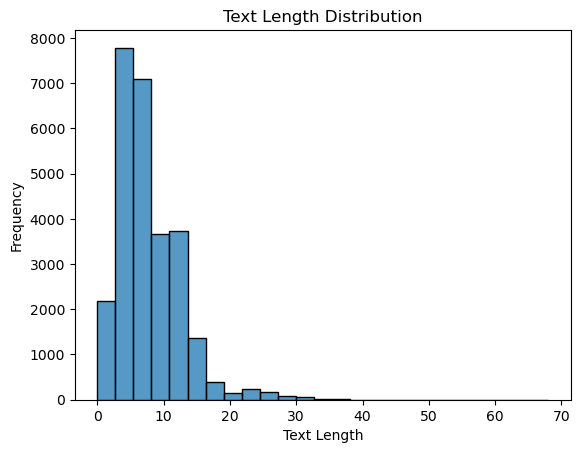

In [17]:
df['text_length'] = df['cleaned_tweet'].apply(lambda x: len(x.split()))
sns.histplot(df['text_length'], bins=25)
plt.title('Text Length Distribution')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

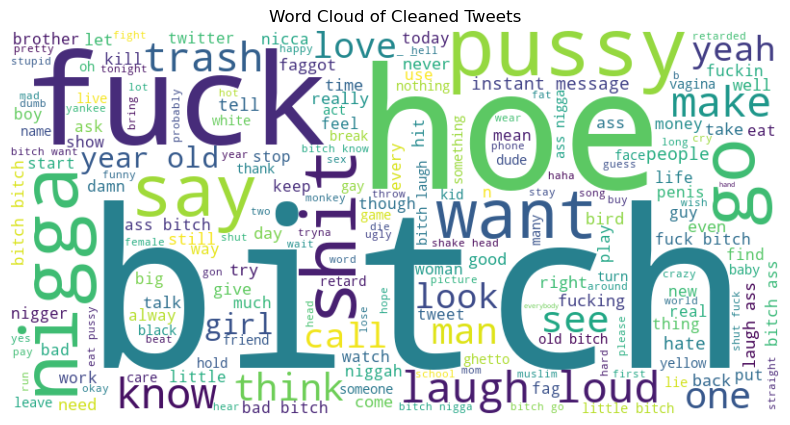

In [18]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df['cleaned_tweet']))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Cleaned Tweets')
plt.show()

# Feature Extraction

In [53]:
tfidf_vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1, 2), 
                                   stop_words='english')
X = tfidf_vectorizer.fit_transform(df['cleaned_tweet'])
y = df['class']

Exploratory Data Analysis on TF-IDF

In [20]:
tfidf_df = pd.DataFrame(X.toarray(), 
                        columns=tfidf_vectorizer.get_feature_names_out())
print(f'TF-IDF matrix shape: {X.shape}')

print(tfidf_df.head())

TF-IDF matrix shape: (26922, 1000)
   absolutely  accept  account  act  act like  actin  action  actually  add  \
0         0.0     0.0      0.0  0.0       0.0    0.0     0.0       0.0  0.0   
1         0.0     0.0      0.0  0.0       0.0    0.0     0.0       0.0  0.0   
2         0.0     0.0      0.0  0.0       0.0    0.0     0.0       0.0  0.0   
3         0.0     0.0      0.0  0.0       0.0    0.0     0.0       0.0  0.0   
4         0.0     0.0      0.0  0.0       0.0    0.0     0.0       0.0  0.0   

   admit  ...      yeah  yeah bitch  year  year old  yellow  yes  yesterday  \
0    0.0  ...  0.000000         0.0   0.0       0.0     0.0  0.0        0.0   
1    0.0  ...  0.000000         0.0   0.0       0.0     0.0  0.0        0.0   
2    0.0  ...  0.000000         0.0   0.0       0.0     0.0  0.0        0.0   
3    0.0  ...  0.000000         0.0   0.0       0.0     0.0  0.0        0.0   
4    0.0  ...  0.325092         0.0   0.0       0.0     0.0  0.0        0.0   

   york  young 

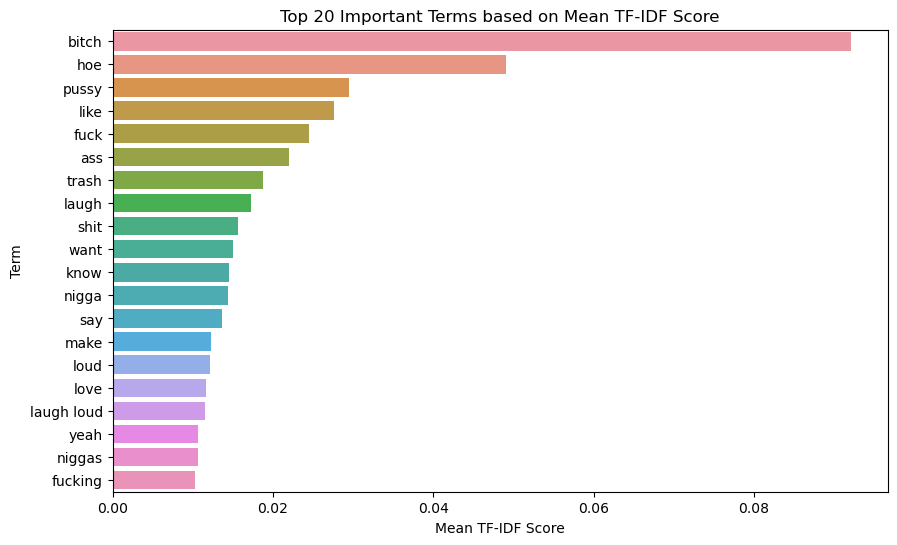

In [21]:
mean_tfidf = tfidf_df.mean().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=mean_tfidf.values[:20], y=mean_tfidf.index[:20])
plt.title('Top 20 Important Terms based on Mean TF-IDF Score')
plt.xlabel('Mean TF-IDF Score')
plt.ylabel('Term')
plt.show()

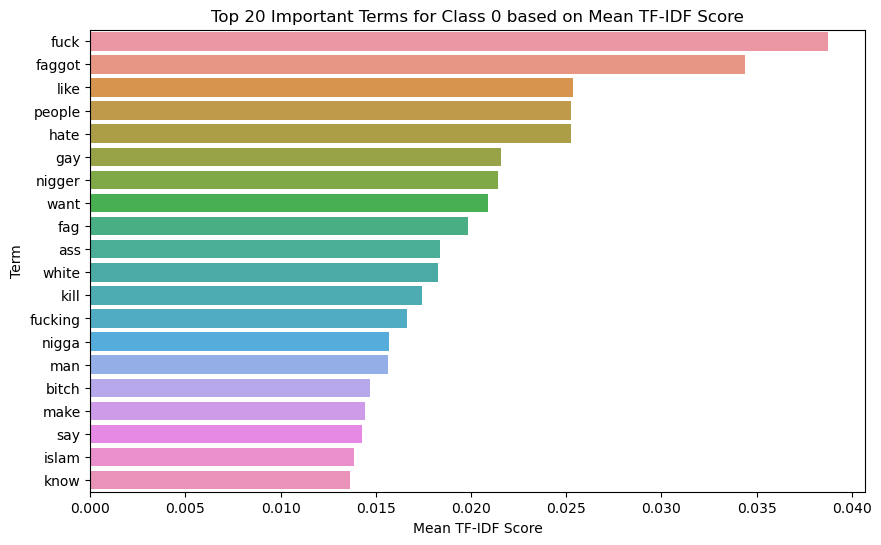

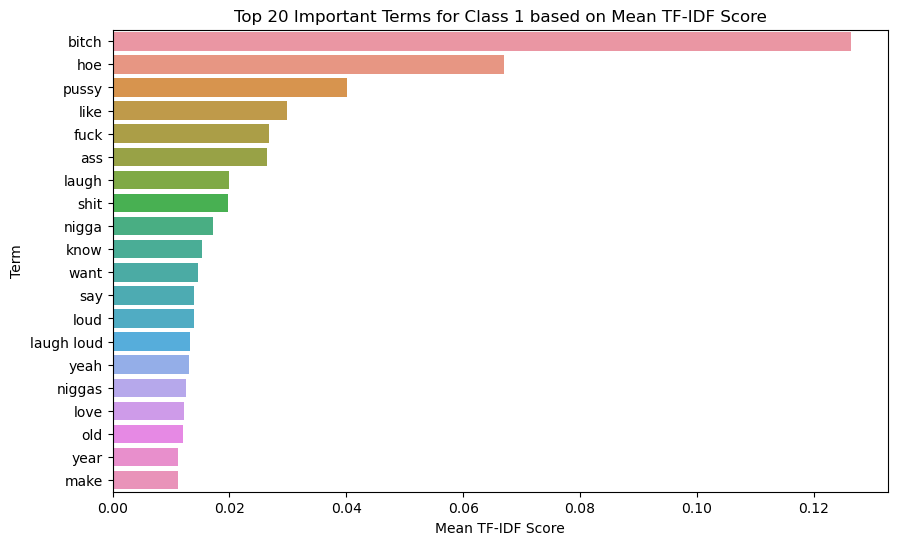

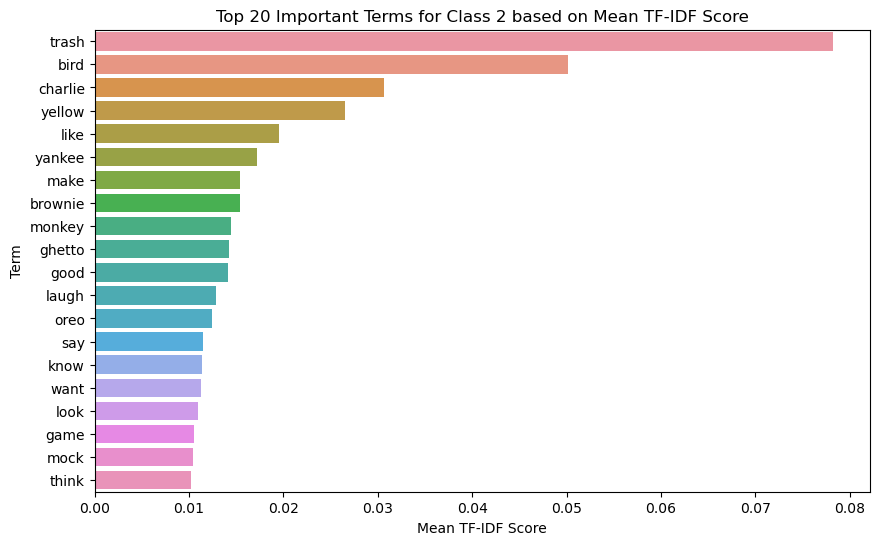

In [22]:
tfidf_df['class'] = df['class']

# Compute the mean TF-IDF score for each term by class
class_means = tfidf_df.groupby('class').mean().T

for cls in class_means.columns:
    plt.figure(figsize=(10, 6))
    class_mean = class_means[cls].sort_values(ascending=False)
    sns.barplot(x=class_mean.values[:20], y=class_mean.index[:20])
    plt.title(f'Top 20 Important Terms for Class {cls} based on Mean TF-IDF Score')
    plt.xlabel('Mean TF-IDF Score')
    plt.ylabel('Term')
    plt.show()

# Defining baseline model

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="stratified", random_state=42)
dummy_clf.fit(X_train, y_train)
y_pred = dummy_clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.5520891364902507

Classification Report:
               precision    recall  f1-score   support

           0       0.12      0.11      0.12       724
           1       0.71      0.72      0.72      3812
           2       0.16      0.15      0.15       849

    accuracy                           0.55      5385
   macro avg       0.33      0.33      0.33      5385
weighted avg       0.54      0.55      0.55      5385



# Model building

## Logistic Regression

In [22]:
log_model = make_pipeline(StandardScaler(with_mean=False), LogisticRegression(max_iter=2000, solver='liblinear', random_state=42))

y_pred_log_reg = cross_val_predict(log_model, X_train, y_train, cv=5)
cv = KFold(n_splits=5, shuffle=True, random_state=42)
lr_scores = cross_val_score(log_model, X_train, y_train, cv=cv, scoring='accuracy')
print("Cross-validation scores:", lr_scores)
print("Mean cross-validation score:", lr_scores.mean())

print("Logistic Regression")
print("Accuracy:", accuracy_score(y_train, y_pred_log_reg))
print("\nClassification Report:\n", classification_report(y_train, y_pred_log_reg))
print("\nConfusion Matrix:\n", confusion_matrix(y_train, y_pred_log_reg))

Cross-validation scores: [0.87488394 0.86258124 0.87067564 0.87531925 0.86812166]
Mean cross-validation score: 0.8703163471009493
Logistic Regression
Accuracy: 0.8721270371918094

Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.58      0.64      2845
           1       0.91      0.94      0.92     15378
           2       0.78      0.83      0.81      3314

    accuracy                           0.87     21537
   macro avg       0.81      0.78      0.79     21537
weighted avg       0.87      0.87      0.87     21537


Confusion Matrix:
 [[ 1652   944   249]
 [  488 14383   507]
 [  160   406  2748]]


In [23]:
log_model.fit(X_train, y_train)

y_pred_test = log_model.predict(X_test)

print("Logistic Regression (Test Data)")
print("Accuracy:", accuracy_score(y_test, y_pred_test))
print("\nClassification Report:\n", classification_report(y_test, y_pred_test))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_test))

Logistic Regression (Test Data)
Accuracy: 0.8802228412256268

Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.59      0.67       724
           1       0.92      0.94      0.93      3812
           2       0.80      0.85      0.83       849

    accuracy                           0.88      5385
   macro avg       0.83      0.80      0.81      5385
weighted avg       0.88      0.88      0.88      5385


Confusion Matrix:
 [[ 430  236   58]
 [ 107 3588  117]
 [  31   96  722]]


## Random Forest

In [24]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
y_pred_rf = cross_val_predict(rf_model, X_train, y_train, cv=cv)
rf_scores = cross_val_score(rf_model, X_train, y_train, cv=cv, scoring='accuracy')

print("Cross-validation scores:", rf_scores)
print("Mean cross-validation score:", rf_scores.mean())

print("RF Classification Report:\n", classification_report(y_train, y_pred_rf))
print("RF Confusion Matrix:\n", confusion_matrix(y_train, y_pred_rf))

Cross-validation scores: [0.88277623 0.86977716 0.87369399 0.87926631 0.88367773]
Mean cross-validation score: 0.8778382840311565
RF Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.55      0.65      2845
           1       0.91      0.94      0.93     15378
           2       0.78      0.86      0.82      3314

    accuracy                           0.88     21537
   macro avg       0.82      0.79      0.80     21537
weighted avg       0.87      0.88      0.87     21537

RF Confusion Matrix:
 [[ 1577  1031   237]
 [  338 14474   566]
 [  128   331  2855]]


In [25]:
rf_model.fit(X_train, y_train)

y_pred_test_rf = rf_model.predict(X_test)

print("Random Forest (Test Data)")
print("Accuracy:", accuracy_score(y_test, y_pred_test_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_test_rf))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_test_rf))

Random Forest (Test Data)
Accuracy: 0.8839368616527391

Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.57      0.66       724
           1       0.92      0.94      0.93      3812
           2       0.81      0.88      0.84       849

    accuracy                           0.88      5385
   macro avg       0.83      0.80      0.81      5385
weighted avg       0.88      0.88      0.88      5385


Confusion Matrix:
 [[ 416  250   58]
 [  90 3601  121]
 [  35   71  743]]


##  Support Vector Machines (SVMs)

In [27]:
svm_model = make_pipeline(StandardScaler(with_mean=False), LinearSVC(max_iter=500000, C=1.0, random_state=42))

cv = KFold(n_splits=5, shuffle=True, random_state=42)
y_pred_svm = cross_val_predict(svm_model, X_train, y_train, cv=cv)
svm_scores = cross_val_score(svm_model, X_train, y_train, cv=cv, scoring='accuracy')

print("Cross-validation scores:", svm_scores)
print("Mean cross-validation score:", svm_scores.mean())

print("SVM Classification Report:\n", classification_report(y_train, y_pred_svm))
print("SVM Confusion Matrix:\n", confusion_matrix(y_train, y_pred_svm))

Cross-validation scores: [0.87883008 0.86931291 0.87230091 0.87903413 0.86835384]
Mean cross-validation score: 0.8735663736712429
SVM Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.57      0.64      2845
           1       0.91      0.94      0.93     15378
           2       0.78      0.83      0.81      3314

    accuracy                           0.87     21537
   macro avg       0.81      0.78      0.79     21537
weighted avg       0.87      0.87      0.87     21537

SVM Confusion Matrix:
 [[ 1632   958   255]
 [  441 14415   522]
 [  145   402  2767]]


In [28]:
svm_model.fit(X_train, y_train)

y_pred_test_svm = svm_model.predict(X_test)

print("Random Forest (Test Data)")
print("Accuracy:", accuracy_score(y_test, y_pred_test_svm))
print("\nClassification Report:\n", classification_report(y_test, y_pred_test_svm))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_test_svm))

Random Forest (Test Data)
Accuracy: 0.8824512534818941

Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.59      0.67       724
           1       0.92      0.94      0.93      3812
           2       0.80      0.87      0.84       849

    accuracy                           0.88      5385
   macro avg       0.83      0.80      0.81      5385
weighted avg       0.88      0.88      0.88      5385


Confusion Matrix:
 [[ 427  239   58]
 [ 103 3588  121]
 [  30   82  737]]


# Word Embeddings - data preparation for deep learning models

In [55]:
from gensim.models import KeyedVectors

glove_file = 'C:/Users/sch/Documents/sch/Final Year Project/glove.twitter.27B.100d.txt'

def load_glove_model(glove_file):
    print("Loading GloVe model...")
    model = KeyedVectors.load_word2vec_format(glove_file, binary=False, no_header=True)
    print("GloVe model loaded.")
    return model

glove_model = load_glove_model(glove_file)

Loading GloVe model...
GloVe model loaded.


# LSTM

In [56]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['cleaned_tweet'])
sequences = tokenizer.texts_to_sequences(df['cleaned_tweet'])

# Pad sequences to ensure uniform input size
max_length = 100
X = pad_sequences(sequences, maxlen=max_length)
y = df['class']

In [57]:
embedding_dim = 100
vocab_size = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in tokenizer.word_index.items():
    if word in glove_model:
        embedding_matrix[i] = glove_model[word]

In [58]:
print(embedding_matrix.shape)

(18627, 100)


In [59]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, 
                    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                    trainable=False))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64))
model.add(Dense(3, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.1)

Epoch 1/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 61s 185ms/step - accuracy: 0.7861 - loss: 0.5483 - val_accuracy: 0.8733 - val_loss: 0.3348
Epoch 2/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 55s 181ms/step - accuracy: 0.8689 - loss: 0.3430 - val_accuracy: 0.8802 - val_loss: 0.3043
Epoch 3/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 56s 186ms/step - accuracy: 0.8834 - loss: 0.3173 - val_accuracy: 0.8895 - val_loss: 0.2908
Epoch 4/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 56s 184ms/step - accuracy: 0.8926 - loss: 0.2934 - val_accuracy: 0.8997 - val_loss: 0.2763
Epoch 5/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 55s 182ms/step - accuracy: 0.8953 - loss: 0.2753 - val_accuracy: 0.8969 - val_loss: 0.2844
Epoch 6/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 56s 183ms/step - accuracy: 0.9011 - loss: 0.2629 - val_accuracy: 0.8946 - val_loss: 0.2914
Epoch 7/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 58s 192ms/step - accuracy: 0.9112 - loss: 0.2449 - val_accuracy: 0.8965 - val_loss: 0.2793
Epoch 8/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 57s 187ms/step - accuracy: 0.9209 - loss: 0

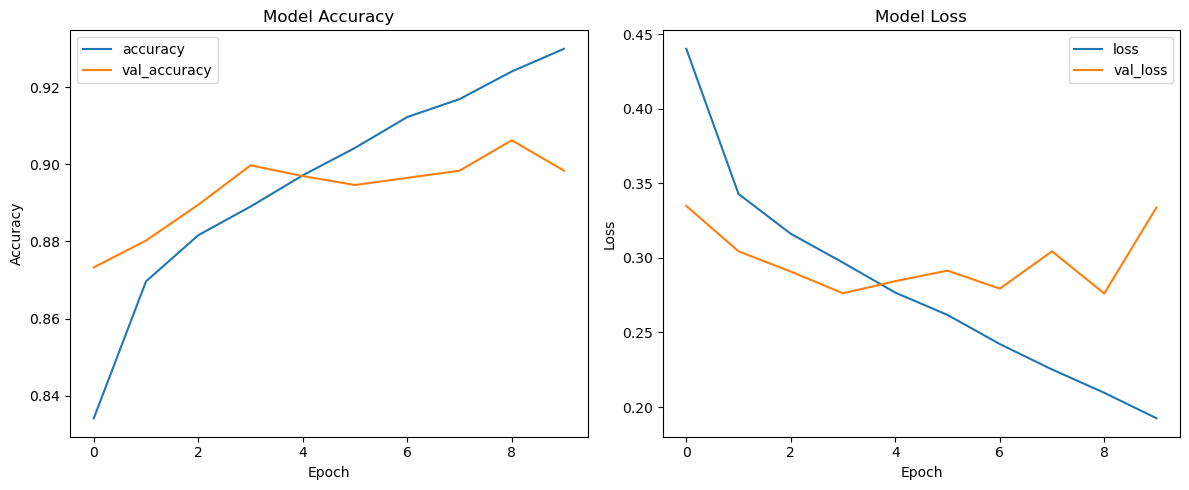

In [60]:
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['accuracy', 'val_accuracy'])

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['loss', 'val_loss'])

plt.tight_layout()
plt.show()

In [61]:
y_pred_lstm = model.predict(X_test)
y_pred = np.argmax(y_pred_lstm, axis=1)  # Convert probabilities to class labels

print(classification_report(y_test, y_pred, target_names=['class 0', 'class 1', 'class 2']))

169/169 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step
              precision    recall  f1-score   support

     class 0       0.78      0.58      0.66       724
     class 1       0.92      0.94      0.93      3812
     class 2       0.80      0.91      0.85       849

    accuracy                           0.89      5385
   macro avg       0.83      0.81      0.82      5385
weighted avg       0.89      0.89      0.88      5385



In [67]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, 
                    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                    trainable=False))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64))
model.add(Dense(3, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

early_stopping = EarlyStopping(
    monitor='val_loss',      # Monitors the validation loss
    patience=3,              # Number of epochs with no improvement before stopping
    restore_best_weights=True  # Restores the weights of the best epoch
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
history = model.fit(X_train, y_train, epochs=15, batch_size=64, validation_split=0.1,callbacks=[early_stopping])

Epoch 1/15
303/303 ━━━━━━━━━━━━━━━━━━━━ 29s 86ms/step - accuracy: 0.7819 - loss: 0.5605 - val_accuracy: 0.8742 - val_loss: 0.3312
Epoch 2/15
303/303 ━━━━━━━━━━━━━━━━━━━━ 26s 87ms/step - accuracy: 0.8676 - loss: 0.3475 - val_accuracy: 0.8872 - val_loss: 0.2987
Epoch 3/15
303/303 ━━━━━━━━━━━━━━━━━━━━ 27s 89ms/step - accuracy: 0.8809 - loss: 0.3172 - val_accuracy: 0.8937 - val_loss: 0.2846
Epoch 4/15
303/303 ━━━━━━━━━━━━━━━━━━━━ 26s 87ms/step - accuracy: 0.8963 - loss: 0.2874 - val_accuracy: 0.8951 - val_loss: 0.2907
Epoch 5/15
303/303 ━━━━━━━━━━━━━━━━━━━━ 26s 86ms/step - accuracy: 0.8997 - loss: 0.2759 - val_accuracy: 0.9016 - val_loss: 0.2728
Epoch 6/15
303/303 ━━━━━━━━━━━━━━━━━━━━ 26s 86ms/step - accuracy: 0.9071 - loss: 0.2534 - val_accuracy: 0.8955 - val_loss: 0.2802
Epoch 7/15
303/303 ━━━━━━━━━━━━━━━━━━━━ 27s 91ms/step - accuracy: 0.9122 - loss: 0.2353 - val_accuracy: 0.9002 - val_loss: 0.2834
Epoch 8/15
303/303 ━━━━━━━━━━━━━━━━━━━━ 26s 87ms/step - accuracy: 0.9213 - loss: 0.2155 - 

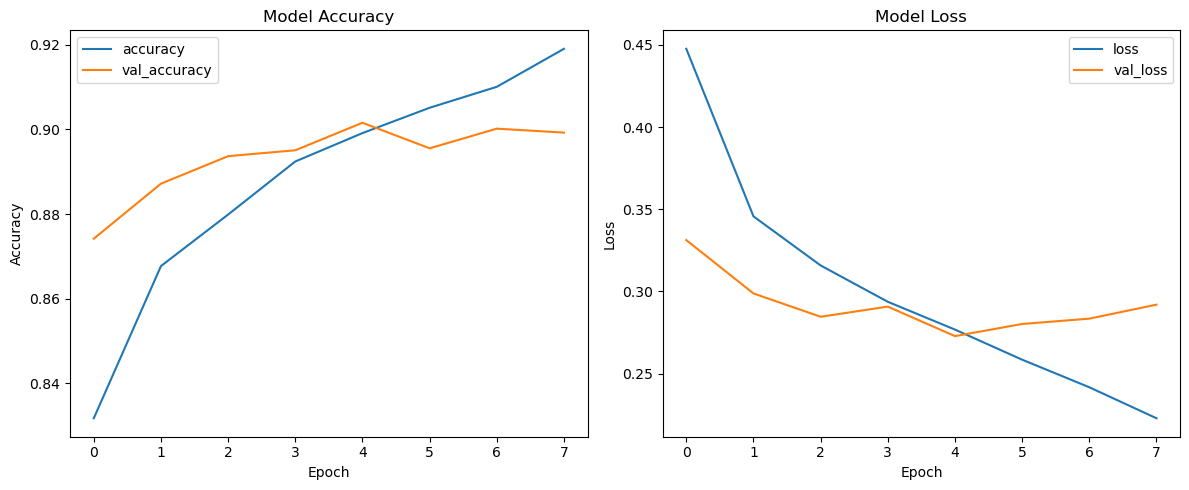

In [68]:
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['accuracy', 'val_accuracy'])

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['loss', 'val_loss'])

plt.tight_layout()
plt.show()

In [69]:
y_pred_lstm = model.predict(X_test)
y_pred = np.argmax(y_pred_lstm, axis=1) 

print(classification_report(y_test, y_pred, target_names=['class 0', 'class 1', 'class 2']))

169/169 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step
              precision    recall  f1-score   support

     class 0       0.76      0.61      0.67       724
     class 1       0.93      0.93      0.93      3812
     class 2       0.80      0.92      0.85       849

    accuracy                           0.89      5385
   macro avg       0.83      0.82      0.82      5385
weighted avg       0.89      0.89      0.89      5385



In [70]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5, 
    patience=3, 
    min_lr=1e-6
)

history = model.fit(X_train,y_train,epochs=15,batch_size=64,validation_split=0.1,callbacks=[early_stopping, reduce_lr])

Epoch 1/15
303/303 ━━━━━━━━━━━━━━━━━━━━ 27s 88ms/step - accuracy: 0.9065 - loss: 0.2559 - val_accuracy: 0.9016 - val_loss: 0.2779 - learning_rate: 0.0010
Epoch 2/15
303/303 ━━━━━━━━━━━━━━━━━━━━ 26s 86ms/step - accuracy: 0.9062 - loss: 0.2437 - val_accuracy: 0.9002 - val_loss: 0.2730 - learning_rate: 0.0010
Epoch 3/15
303/303 ━━━━━━━━━━━━━━━━━━━━ 27s 88ms/step - accuracy: 0.9180 - loss: 0.2174 - val_accuracy: 0.8993 - val_loss: 0.3030 - learning_rate: 0.0010


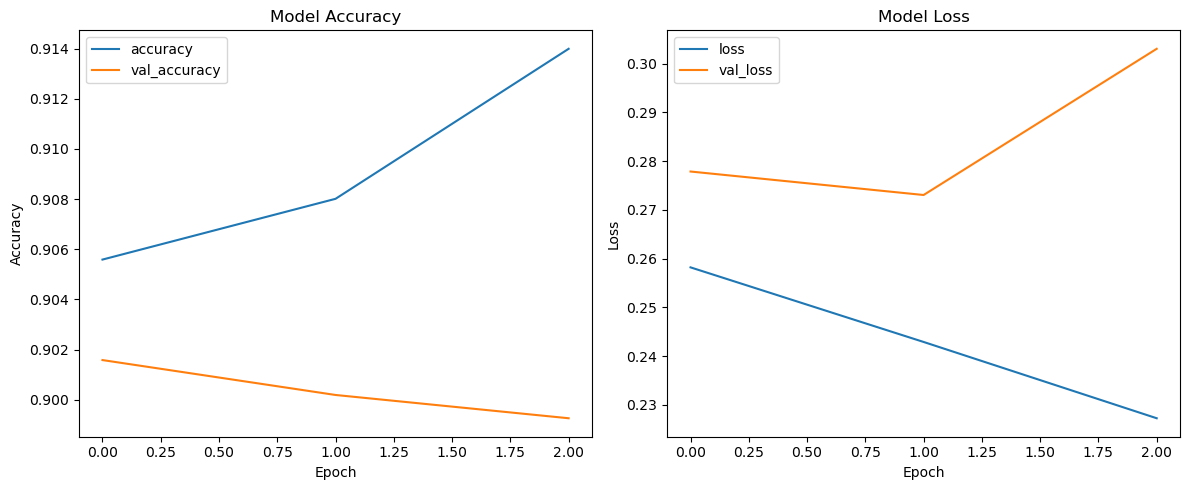

In [71]:
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['accuracy', 'val_accuracy'])

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['loss', 'val_loss'])

plt.tight_layout()
plt.show()

In [72]:
y_pred_lstm = model.predict(X_test)
y_pred = np.argmax(y_pred_lstm, axis=1) 

print(classification_report(y_test, y_pred, target_names=['class 0', 'class 1', 'class 2']))

169/169 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step
              precision    recall  f1-score   support

     class 0       0.78      0.58      0.66       724
     class 1       0.92      0.95      0.93      3812
     class 2       0.83      0.89      0.86       849

    accuracy                           0.89      5385
   macro avg       0.84      0.81      0.82      5385
weighted avg       0.89      0.89      0.89      5385



# BiLSTM with CNN
Combining CNN and LSTM, adding bidirectional LSTM to capture dependencies:

In [62]:
model2 = Sequential()
model2.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, 
                    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                     trainable=True))
model2.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model2.add(MaxPooling1D(pool_size=2))
model2.add(Bidirectional(LSTM(128, return_sequences=True)))
model2.add(Dropout(0.5))
model2.add(LSTM(64))
model2.add(Dense(3, activation='softmax'))
model2.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
history = model2.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.1)

Epoch 1/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 42s 117ms/step - accuracy: 0.7968 - loss: 0.5274 - val_accuracy: 0.8816 - val_loss: 0.3083
Epoch 2/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 35s 115ms/step - accuracy: 0.8996 - loss: 0.2753 - val_accuracy: 0.9002 - val_loss: 0.2810
Epoch 3/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 35s 116ms/step - accuracy: 0.9331 - loss: 0.1971 - val_accuracy: 0.8965 - val_loss: 0.3180
Epoch 4/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 35s 116ms/step - accuracy: 0.9573 - loss: 0.1306 - val_accuracy: 0.8821 - val_loss: 0.4042
Epoch 5/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 35s 116ms/step - accuracy: 0.9702 - loss: 0.0938 - val_accuracy: 0.8728 - val_loss: 0.4407
Epoch 6/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 35s 114ms/step - accuracy: 0.9767 - loss: 0.0727 - val_accuracy: 0.8714 - val_loss: 0.4895
Epoch 7/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 35s 117ms/step - accuracy: 0.9837 - loss: 0.0524 - val_accuracy: 0.8700 - val_loss: 0.5564
Epoch 8/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 35s 116ms/step - accuracy: 0.9860 - loss: 0

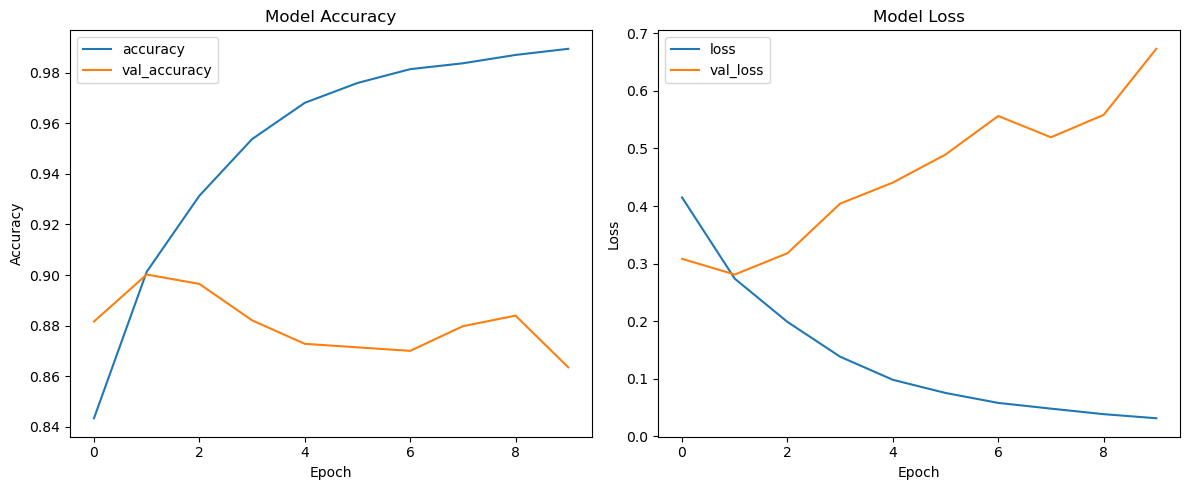

In [63]:
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['accuracy', 'val_accuracy'])

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['loss', 'val_loss'])

plt.tight_layout()
plt.show()

In [64]:
y_pred_lstm2 = model2.predict(X_test)
y_pred2 = np.argmax(y_pred_lstm2, axis=1)  

print(classification_report(y_test, y_pred2, target_names=['class 0', 'class 1', 'class 2']))

169/169 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step
              precision    recall  f1-score   support

     class 0       0.73      0.57      0.64       724
     class 1       0.89      0.94      0.92      3812
     class 2       0.83      0.77      0.80       849

    accuracy                           0.87      5385
   macro avg       0.82      0.76      0.78      5385
weighted avg       0.86      0.87      0.86      5385



In [73]:
model2 = Sequential()
model2.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, 
                    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                     trainable=True))
model2.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model2.add(MaxPooling1D(pool_size=2))
model2.add(Bidirectional(LSTM(128, return_sequences=True)))
model2.add(Dropout(0.5))
model2.add(LSTM(64))
model2.add(Dense(3, activation='softmax'))
model2.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

early_stopping = EarlyStopping(
    monitor='val_loss',      
    patience=3,              
    restore_best_weights=True  
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
history = model2.fit(X_train, y_train, epochs=15, batch_size=64, validation_split=0.1,callbacks=[early_stopping])

Epoch 1/15
303/303 ━━━━━━━━━━━━━━━━━━━━ 25s 72ms/step - accuracy: 0.8021 - loss: 0.5156 - val_accuracy: 0.8779 - val_loss: 0.3325
Epoch 2/15
303/303 ━━━━━━━━━━━━━━━━━━━━ 22s 74ms/step - accuracy: 0.9003 - loss: 0.2736 - val_accuracy: 0.8979 - val_loss: 0.2892
Epoch 3/15
303/303 ━━━━━━━━━━━━━━━━━━━━ 22s 72ms/step - accuracy: 0.9350 - loss: 0.1903 - val_accuracy: 0.8886 - val_loss: 0.3070
Epoch 4/15
303/303 ━━━━━━━━━━━━━━━━━━━━ 20s 67ms/step - accuracy: 0.9582 - loss: 0.1329 - val_accuracy: 0.8784 - val_loss: 0.3407
Epoch 5/15
303/303 ━━━━━━━━━━━━━━━━━━━━ 20s 67ms/step - accuracy: 0.9709 - loss: 0.0883 - val_accuracy: 0.8774 - val_loss: 0.4106


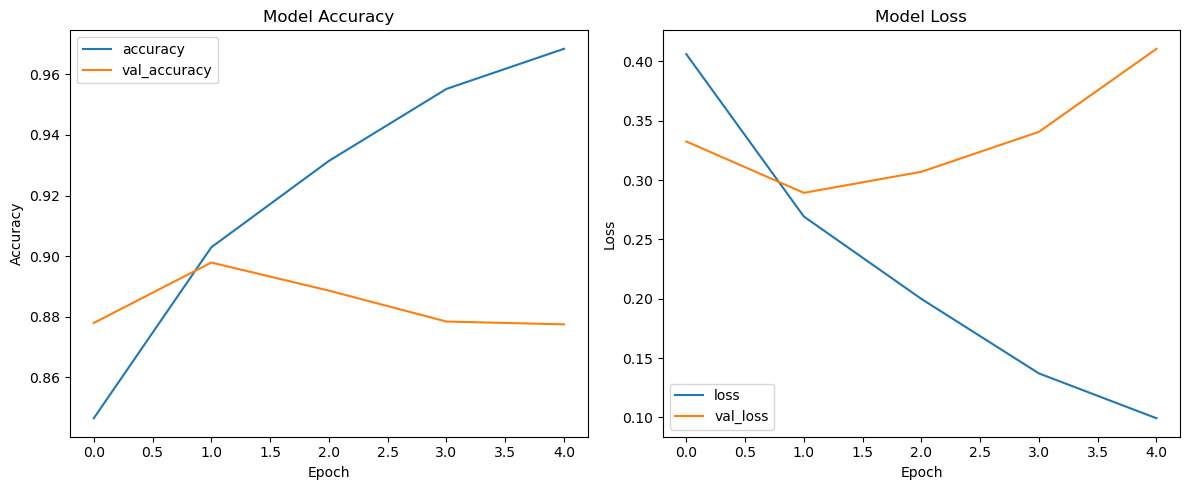

In [74]:
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['accuracy', 'val_accuracy'])

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['loss', 'val_loss'])

plt.tight_layout()
plt.show()

In [75]:
y_pred_lstm2 = model2.predict(X_test)
y_pred2 = np.argmax(y_pred_lstm2, axis=1)  

print(classification_report(y_test, y_pred2, target_names=['class 0', 'class 1', 'class 2']))

169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step
              precision    recall  f1-score   support

     class 0       0.85      0.54      0.66       724
     class 1       0.92      0.95      0.93      3812
     class 2       0.79      0.93      0.85       849

    accuracy                           0.89      5385
   macro avg       0.85      0.81      0.82      5385
weighted avg       0.89      0.89      0.88      5385



Implementing Learning rate scheduler (fine-tuning):

In [76]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Monitors validation loss
    factor=0.5,          # Reduces learning rate by half
    patience=2,          # Waits for 2 epochs of no improvement
    min_lr=1e-6          # Minimum learning rate
)

history = model2.fit(X_train, y_train, epochs=15, batch_size=64, validation_split=0.1, callbacks=[early_stopping, reduce_lr])

Epoch 1/15
303/303 ━━━━━━━━━━━━━━━━━━━━ 27s 82ms/step - accuracy: 0.7948 - loss: 0.5435 - val_accuracy: 0.8728 - val_loss: 0.3377 - learning_rate: 0.0010
Epoch 2/15
303/303 ━━━━━━━━━━━━━━━━━━━━ 24s 80ms/step - accuracy: 0.8669 - loss: 0.3517 - val_accuracy: 0.8890 - val_loss: 0.3027 - learning_rate: 0.0010
Epoch 3/15
303/303 ━━━━━━━━━━━━━━━━━━━━ 24s 80ms/step - accuracy: 0.8795 - loss: 0.3137 - val_accuracy: 0.8928 - val_loss: 0.2893 - learning_rate: 0.0010
Epoch 4/15
303/303 ━━━━━━━━━━━━━━━━━━━━ 24s 80ms/step - accuracy: 0.8912 - loss: 0.2929 - val_accuracy: 0.8988 - val_loss: 0.2804 - learning_rate: 0.0010
Epoch 5/15
303/303 ━━━━━━━━━━━━━━━━━━━━ 25s 81ms/step - accuracy: 0.8985 - loss: 0.2712 - val_accuracy: 0.8932 - val_loss: 0.2974 - learning_rate: 0.0010
Epoch 6/15
303/303 ━━━━━━━━━━━━━━━━━━━━ 24s 80ms/step - accuracy: 0.9045 - loss: 0.2633 - val_accuracy: 0.8979 - val_loss: 0.2827 - learning_rate: 0.0010
Epoch 7/15
303/303 ━━━━━━━━━━━━━━━━━━━━ 25s 81ms/step - accuracy: 0.9136 - l

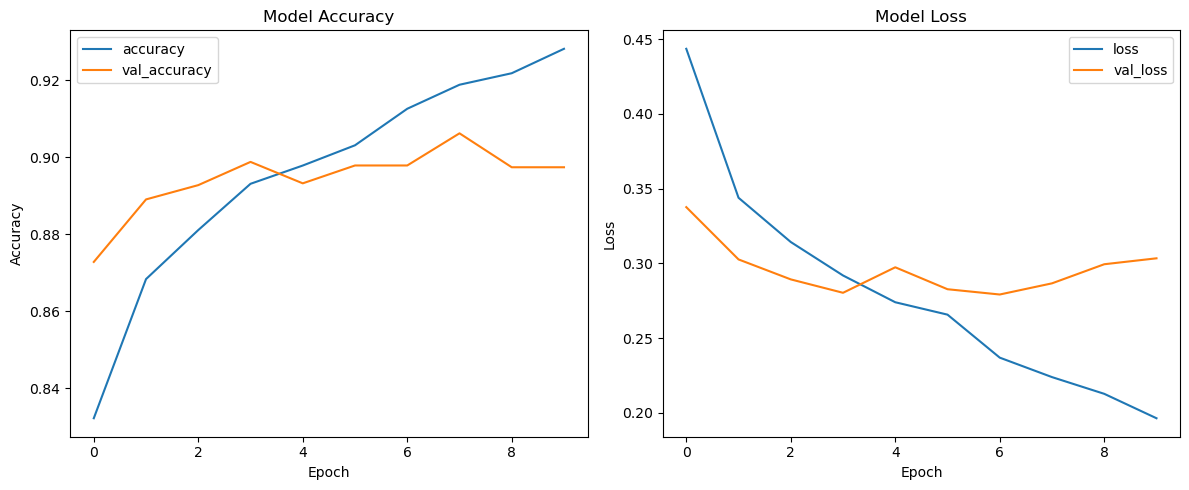

In [77]:
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['accuracy', 'val_accuracy'])

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['loss', 'val_loss'])

plt.tight_layout()
plt.show()

In [78]:
y_pred_lstm = model.predict(X_test)
y_pred = np.argmax(y_pred_lstm, axis=1)  

print(classification_report(y_test, y_pred, target_names=['class 0', 'class 1', 'class 2']))

169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step
              precision    recall  f1-score   support

     class 0       0.78      0.58      0.66       724
     class 1       0.92      0.95      0.93      3812
     class 2       0.83      0.89      0.86       849

    accuracy                           0.89      5385
   macro avg       0.84      0.81      0.82      5385
weighted avg       0.89      0.89      0.89      5385



# BiLSTM
Only bidirectional LSTM layer added:

In [79]:
model3 = Sequential()
model3.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, 
                    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                    trainable=False))
model3.add(Bidirectional(LSTM(128, return_sequences=True)))
model3.add(Dropout(0.5))
model3.add(LSTM(64))
model3.add(Dense(3, activation='softmax'))
model3.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
history = model3.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.1)

Epoch 1/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 37s 108ms/step - accuracy: 0.8165 - loss: 0.4927 - val_accuracy: 0.8774 - val_loss: 0.3286
Epoch 2/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 33s 110ms/step - accuracy: 0.8726 - loss: 0.3335 - val_accuracy: 0.8923 - val_loss: 0.3029
Epoch 3/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 33s 108ms/step - accuracy: 0.8885 - loss: 0.2988 - val_accuracy: 0.9011 - val_loss: 0.2837
Epoch 4/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 32s 105ms/step - accuracy: 0.8978 - loss: 0.2789 - val_accuracy: 0.8942 - val_loss: 0.2957
Epoch 5/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 31s 103ms/step - accuracy: 0.9054 - loss: 0.2580 - val_accuracy: 0.9034 - val_loss: 0.2911
Epoch 6/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 29s 97ms/step - accuracy: 0.9168 - loss: 0.2316 - val_accuracy: 0.9085 - val_loss: 0.2995
Epoch 7/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 29s 97ms/step - accuracy: 0.9215 - loss: 0.2226 - val_accuracy: 0.8937 - val_loss: 0.2981
Epoch 8/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 29s 97ms/step - accuracy: 0.9337 - loss: 0.18

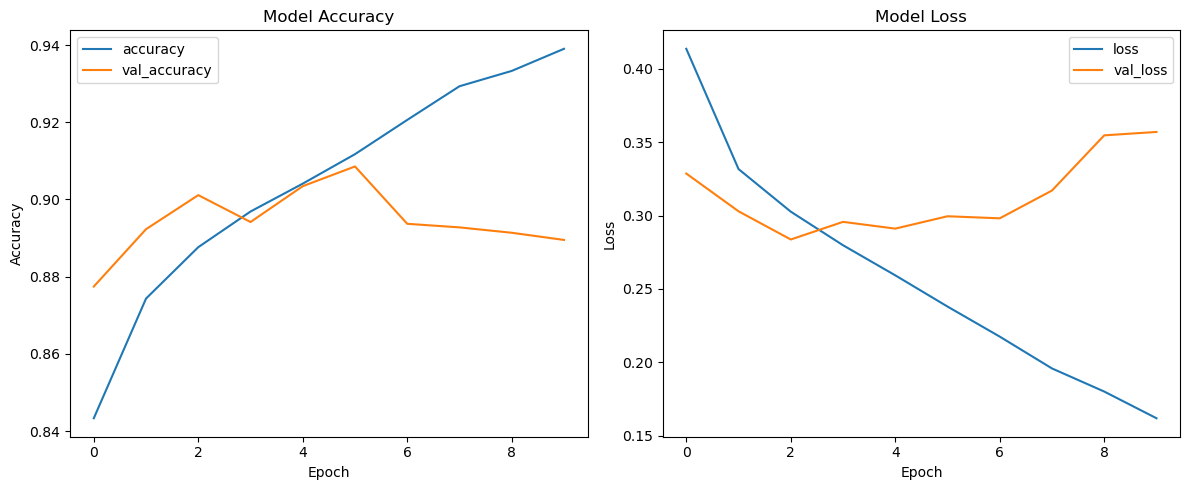

In [80]:
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['accuracy', 'val_accuracy'])

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['loss', 'val_loss'])

plt.tight_layout()
plt.show()

In [81]:
y_pred_lstm3 = model3.predict(X_test)
y_pred3 = np.argmax(y_pred_lstm3, axis=1)  

print(classification_report(y_test, y_pred3, target_names=['class 0', 'class 1', 'class 2']))

169/169 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step
              precision    recall  f1-score   support

     class 0       0.76      0.64      0.69       724
     class 1       0.93      0.94      0.93      3812
     class 2       0.81      0.86      0.83       849

    accuracy                           0.89      5385
   macro avg       0.83      0.81      0.82      5385
weighted avg       0.89      0.89      0.89      5385



Implementing early stopping:

In [82]:
model3 = Sequential()
model3.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, 
                    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                    trainable=False))
model3.add(Bidirectional(LSTM(128, return_sequences=True)))
model3.add(Dropout(0.5))
model3.add(LSTM(64))
model3.add(Dense(3, activation='softmax'))
model3.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

early_stopping = EarlyStopping(
    monitor='val_loss',      
    patience=3,              
    restore_best_weights=True  
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
history = model3.fit(X_train, y_train, epochs=15, batch_size=64, validation_split=0.1,callbacks=[early_stopping])

Epoch 1/15
303/303 ━━━━━━━━━━━━━━━━━━━━ 37s 108ms/step - accuracy: 0.7977 - loss: 0.5151 - val_accuracy: 0.8723 - val_loss: 0.3382
Epoch 2/15
303/303 ━━━━━━━━━━━━━━━━━━━━ 34s 111ms/step - accuracy: 0.8718 - loss: 0.3323 - val_accuracy: 0.8881 - val_loss: 0.3027
Epoch 3/15
303/303 ━━━━━━━━━━━━━━━━━━━━ 33s 109ms/step - accuracy: 0.8835 - loss: 0.3111 - val_accuracy: 0.9002 - val_loss: 0.2814
Epoch 4/15
303/303 ━━━━━━━━━━━━━━━━━━━━ 33s 110ms/step - accuracy: 0.8982 - loss: 0.2816 - val_accuracy: 0.8983 - val_loss: 0.2814
Epoch 5/15
303/303 ━━━━━━━━━━━━━━━━━━━━ 33s 110ms/step - accuracy: 0.9036 - loss: 0.2632 - val_accuracy: 0.9030 - val_loss: 0.2766
Epoch 6/15
303/303 ━━━━━━━━━━━━━━━━━━━━ 34s 112ms/step - accuracy: 0.9129 - loss: 0.2382 - val_accuracy: 0.9002 - val_loss: 0.2803
Epoch 7/15
303/303 ━━━━━━━━━━━━━━━━━━━━ 34s 111ms/step - accuracy: 0.9193 - loss: 0.2237 - val_accuracy: 0.9020 - val_loss: 0.3011
Epoch 8/15
303/303 ━━━━━━━━━━━━━━━━━━━━ 34s 111ms/step - accuracy: 0.9290 - loss: 0

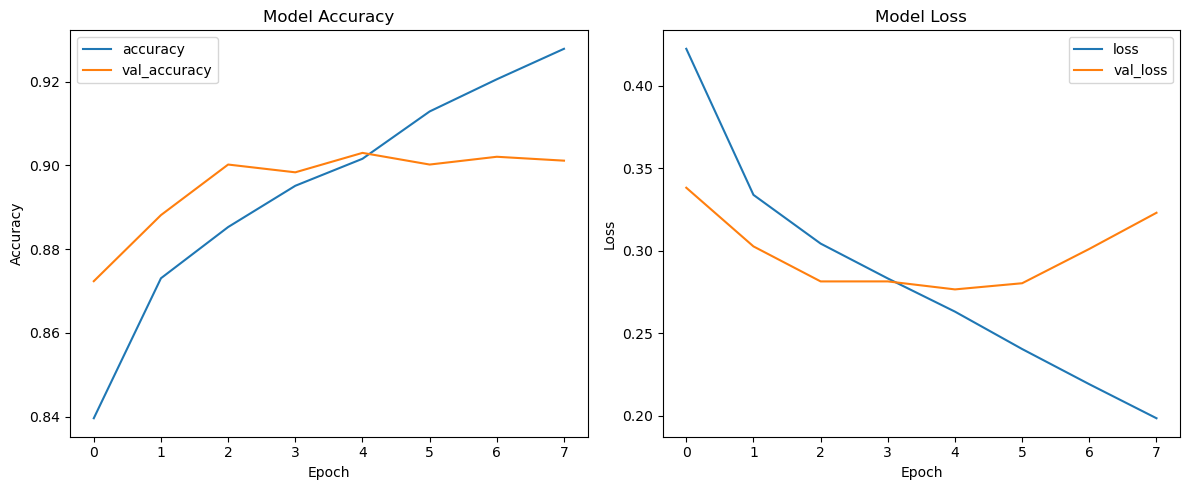

In [83]:
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['accuracy', 'val_accuracy'])

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['loss', 'val_loss'])

plt.tight_layout()
plt.show()

In [84]:
y_pred_lstm3 = model3.predict(X_test)
y_pred3 = np.argmax(y_pred_lstm3, axis=1)  

print(classification_report(y_test, y_pred3, target_names=['class 0', 'class 1', 'class 2']))

169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step
              precision    recall  f1-score   support

     class 0       0.80      0.57      0.66       724
     class 1       0.92      0.95      0.93      3812
     class 2       0.82      0.89      0.85       849

    accuracy                           0.89      5385
   macro avg       0.85      0.80      0.82      5385
weighted avg       0.89      0.89      0.88      5385



fine tuning BiLSTM:

In [85]:
model3 = Sequential()
model3.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, 
                    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                    trainable=False))
model3.add(Bidirectional(LSTM(128, return_sequences=True)))
model3.add(Dropout(0.5))
model3.add(LSTM(64))
model3.add(Dense(3, activation='softmax'))
model3.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

early_stopping = EarlyStopping(
    monitor='val_loss',      
    patience=3,              
    restore_best_weights=True  
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  
    factor=0.5,          
    patience=2,          
    min_lr=1e-6          
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
history = model3.fit(X_train, y_train, epochs=15, batch_size=64, validation_split=0.1,callbacks=[early_stopping, reduce_lr])

Epoch 1/15
303/303 ━━━━━━━━━━━━━━━━━━━━ 36s 110ms/step - accuracy: 0.8006 - loss: 0.5138 - val_accuracy: 0.8816 - val_loss: 0.3267 - learning_rate: 0.0010
Epoch 2/15
303/303 ━━━━━━━━━━━━━━━━━━━━ 33s 108ms/step - accuracy: 0.8740 - loss: 0.3346 - val_accuracy: 0.8890 - val_loss: 0.2963 - learning_rate: 0.0010
Epoch 3/15
303/303 ━━━━━━━━━━━━━━━━━━━━ 32s 107ms/step - accuracy: 0.8800 - loss: 0.3144 - val_accuracy: 0.8932 - val_loss: 0.2922 - learning_rate: 0.0010
Epoch 4/15
303/303 ━━━━━━━━━━━━━━━━━━━━ 32s 104ms/step - accuracy: 0.8948 - loss: 0.2812 - val_accuracy: 0.9081 - val_loss: 0.2722 - learning_rate: 0.0010
Epoch 5/15
303/303 ━━━━━━━━━━━━━━━━━━━━ 31s 103ms/step - accuracy: 0.9074 - loss: 0.2531 - val_accuracy: 0.9067 - val_loss: 0.2830 - learning_rate: 0.0010
Epoch 6/15
303/303 ━━━━━━━━━━━━━━━━━━━━ 33s 109ms/step - accuracy: 0.9157 - loss: 0.2316 - val_accuracy: 0.9006 - val_loss: 0.2915 - learning_rate: 0.0010
Epoch 7/15
303/303 ━━━━━━━━━━━━━━━━━━━━ 32s 105ms/step - accuracy: 0.9

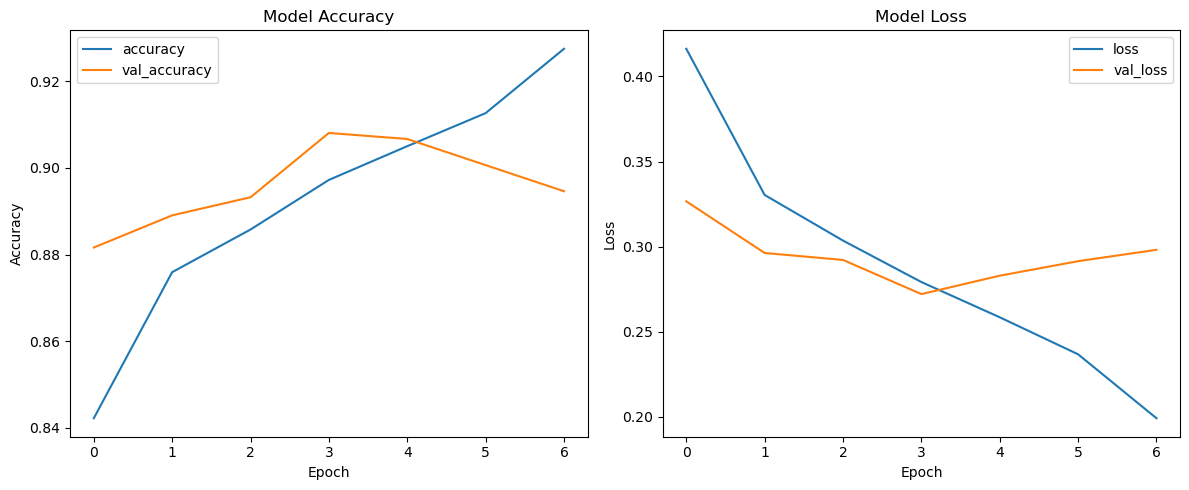

In [86]:
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['accuracy', 'val_accuracy'])

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['loss', 'val_loss'])

plt.tight_layout()
plt.show()

In [87]:
y_pred_lstm3 = model3.predict(X_test)
y_pred3 = np.argmax(y_pred_lstm3, axis=1)  

print(classification_report(y_test, y_pred3, target_names=['class 0', 'class 1', 'class 2']))

169/169 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step
              precision    recall  f1-score   support

     class 0       0.79      0.59      0.67       724
     class 1       0.92      0.95      0.93      3812
     class 2       0.83      0.87      0.85       849

    accuracy                           0.89      5385
   macro avg       0.85      0.80      0.82      5385
weighted avg       0.89      0.89      0.89      5385



# BERT

In [15]:
from datasets import Dataset

dataset = Dataset.from_pandas(df)

In [16]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',clean_up_tokenization_spaces=True)

def tokenize_and_encode(batch):
    return tokenizer(batch['cleaned_tweet'], padding='max_length', truncation=True, max_length=128)

# Tokenize the dataset
tokenized_dataset = dataset.map(tokenize_and_encode, batched=True)

Map:   0%|          | 0/26922 [00:00<?, ? examples/s]

In [17]:
df_tokenized = tokenized_dataset.to_pandas()

# Split into train+validation and test sets
train_val_df, test_df = train_test_split(df_tokenized, test_size=0.2, stratify=df_tokenized['class'], random_state=42)

# Split train+validation into train and validation sets
train_df, val_df = train_test_split(train_val_df, test_size=0.1, stratify=train_val_df['class'], random_state=42)

# Convert DataFrames back to datasets
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

In [18]:
def convert(dataset): # Convert to tensorflow dataset
    return tf.data.Dataset.from_tensor_slices((
        {
            'input_ids': dataset['input_ids'],
            'attention_mask': dataset['attention_mask'],
            'token_type_ids': dataset['token_type_ids']
        },
        dataset['class']
    )).batch(32)

train_tf_dataset = convert(train_dataset)
val_tf_dataset = convert(val_dataset)
test_tf_dataset = convert(test_dataset)

# Transformer model

In [37]:
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)
optimizer = AdamWeightDecay(learning_rate=2e-5, weight_decay_rate=0.01)

model.compile(optimizer=optimizer, 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [38]:
history = model.fit(
    train_tf_dataset,
    validation_data=val_tf_dataset,
    epochs=5,
    batch_size=32
)

results = model.evaluate(test_tf_dataset)
print(f"Test Loss: {results[0]}")
print(f"Test Accuracy: {results[1]}")

Epoch 1/5


606/606 [==============================] - 3214s 5s/step - loss: 0.3824 - accuracy: 0.8567 - val_loss: 0.2698 - val_accuracy: 0.9030
Epoch 2/5
606/606 [==============================] - 3167s 5s/step - loss: 0.2488 - accuracy: 0.9103 - val_loss: 0.2758 - val_accuracy: 0.8951
Epoch 3/5
606/606 [==============================] - 3194s 5s/step - loss: 0.1941 - accuracy: 0.9327 - val_loss: 0.2779 - val_accuracy: 0.9025
Epoch 4/5
606/606 [==============================] - 3178s 5s/step - loss: 0.1548 - accuracy: 0.9447 - val_loss: 0.3720 - val_accuracy: 0.8955
Epoch 5/5
169/169 [==============================] - 262s 2s/step - loss: 0.4749 - accuracy: 0.8819
Test Loss: 0.4748627245426178
Test Accuracy: 0.8818941712379456


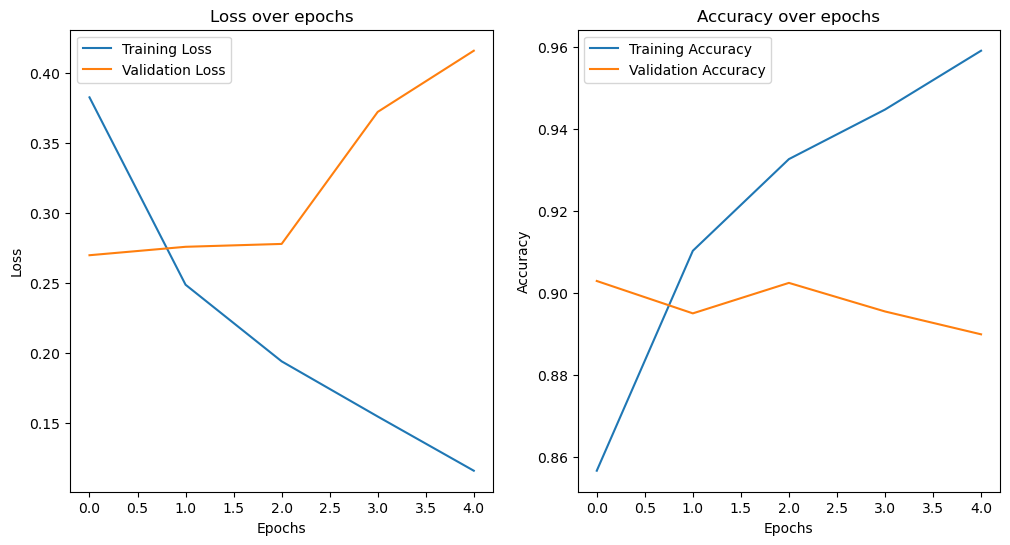

In [39]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [40]:
y_true = np.concatenate([y for x, y in test_tf_dataset], axis=0)

y_pred_probs = model.predict(test_tf_dataset).logits
y_pred = np.argmax(y_pred_probs, axis=1)

report = classification_report(y_true, y_pred, target_names=['Class 0', 'Class 1', 'Class 2'])
print(report)

169/169 [==============================] - 254s 1s/step
              precision    recall  f1-score   support

     Class 0       0.68      0.72      0.70       714
     Class 1       0.95      0.91      0.93      3838
     Class 2       0.78      0.91      0.84       833

    accuracy                           0.88      5385
   macro avg       0.80      0.84      0.82      5385
weighted avg       0.89      0.88      0.88      5385



Adjusting dropout probabilities (hyperparameter tuning):

In [102]:
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3, 
                                                        hidden_dropout_prob=0.2,  
                                                        attention_probs_dropout_prob=0.2)

optimizer = AdamWeightDecay(learning_rate=2e-5, weight_decay_rate=0.01)

model.compile(optimizer=optimizer, 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(
    train_tf_dataset,
    validation_data=val_tf_dataset,
    epochs=3,
    batch_size=32
)

results = model.evaluate(test_tf_dataset)
print(f"Test Loss: {results[0]}")
print(f"Test Accuracy: {results[1]}")

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
606/606 [==============================] - 3451s 6s/step - loss: 0.4155 - accuracy: 0.8400 - val_loss: 0.2920 - val_accuracy: 0.8946
Epoch 2/3
606/606 [==============================] - 3358s 6s/step - loss: 0.2834 - accuracy: 0.8985 - val_loss: 0.2864 - val_accuracy: 0.8969
Epoch 3/3
169/169 [==============================] - 281s 2s/step - loss: 0.3032 - accuracy: 0.9010
Test Loss: 0.30315083265304565
Test Accuracy: 0.9010213613510132


In [103]:
y_true = np.concatenate([y for x, y in test_tf_dataset], axis=0)
y_pred_probs = model.predict(test_tf_dataset).logits
y_pred = np.argmax(y_pred_probs, axis=1)

report = classification_report(y_true, y_pred, target_names=['Class 0', 'Class 1', 'Class 2'])
print(report)

169/169 [==============================] - 281s 2s/step
              precision    recall  f1-score   support

     Class 0       0.73      0.74      0.73       714
     Class 1       0.95      0.93      0.94      3838
     Class 2       0.85      0.89      0.87       833

    accuracy                           0.90      5385
   macro avg       0.84      0.86      0.85      5385
weighted avg       0.90      0.90      0.90      5385



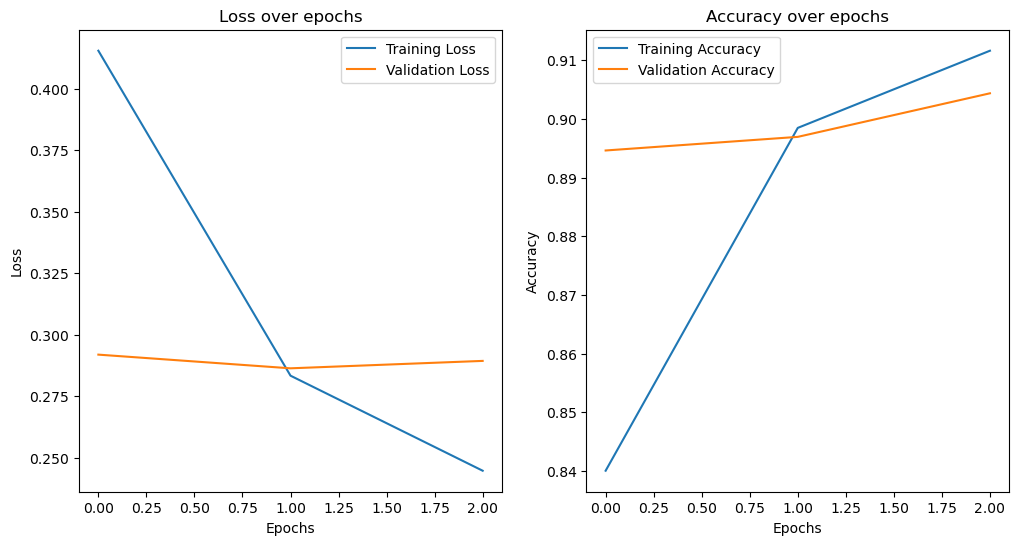

In [104]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# DistilBERT Embeddings with LSTM

In [20]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', clean_up_tokenization_spaces=True)
model = DistilBertModel.from_pretrained('distilbert-base-uncased')
model.eval()
# Extract embeddings function
def get_embeddings(batch, batch_size=32):
    all_embeddings = []
    texts = batch['cleaned_tweet'].tolist()
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(batch_texts, padding='max_length', truncation=True, max_length=128, return_tensors='pt')
        with torch.no_grad():  # Avoid gradients during inference
            outputs = model(**inputs)
        all_embeddings.append(outputs.last_hidden_state)  # shape: (batch_size, sequence_length, hidden_dim)
    return torch.cat(all_embeddings, dim=0)

# Get embeddings for train, validation, and test sets
train_embeddings = get_embeddings(train_df)
val_embeddings = get_embeddings(val_df)
test_embeddings = get_embeddings(test_df)

In [21]:
# Prepare data
train_labels = train_df['class'].values
val_labels = val_df['class'].values
test_labels = test_df['class'].values

bertlstm_model = Sequential([
    Input(shape=(train_embeddings.shape[1], train_embeddings.shape[2])),
    LSTM(128, return_sequences=True),
    Dropout(0.5),
    LSTM(64),
    Dense(3, activation='softmax')  
])

bertlstm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = bertlstm_model.fit(train_embeddings, train_labels, validation_data=(val_embeddings, val_labels), epochs=10)

Epoch 1/10
606/606 ━━━━━━━━━━━━━━━━━━━━ 120s 191ms/step - accuracy: 0.7894 - loss: 0.5475 - val_accuracy: 0.8445 - val_loss: 0.4053
Epoch 2/10
606/606 ━━━━━━━━━━━━━━━━━━━━ 110s 181ms/step - accuracy: 0.8545 - loss: 0.3867 - val_accuracy: 0.8612 - val_loss: 0.3548
Epoch 3/10
606/606 ━━━━━━━━━━━━━━━━━━━━ 112s 184ms/step - accuracy: 0.8691 - loss: 0.3429 - val_accuracy: 0.8672 - val_loss: 0.3500
Epoch 4/10
606/606 ━━━━━━━━━━━━━━━━━━━━ 116s 191ms/step - accuracy: 0.8794 - loss: 0.3114 - val_accuracy: 0.8644 - val_loss: 0.3553
Epoch 5/10
606/606 ━━━━━━━━━━━━━━━━━━━━ 112s 185ms/step - accuracy: 0.8947 - loss: 0.2821 - val_accuracy: 0.8709 - val_loss: 0.3546
Epoch 6/10
606/606 ━━━━━━━━━━━━━━━━━━━━ 114s 188ms/step - accuracy: 0.9021 - loss: 0.2612 - val_accuracy: 0.8691 - val_loss: 0.3704
Epoch 7/10
606/606 ━━━━━━━━━━━━━━━━━━━━ 112s 185ms/step - accuracy: 0.9143 - loss: 0.2339 - val_accuracy: 0.8677 - val_loss: 0.3602
Epoch 8/10
606/606 ━━━━━━━━━━━━━━━━━━━━ 112s 184ms/step - accuracy: 0.9230 -

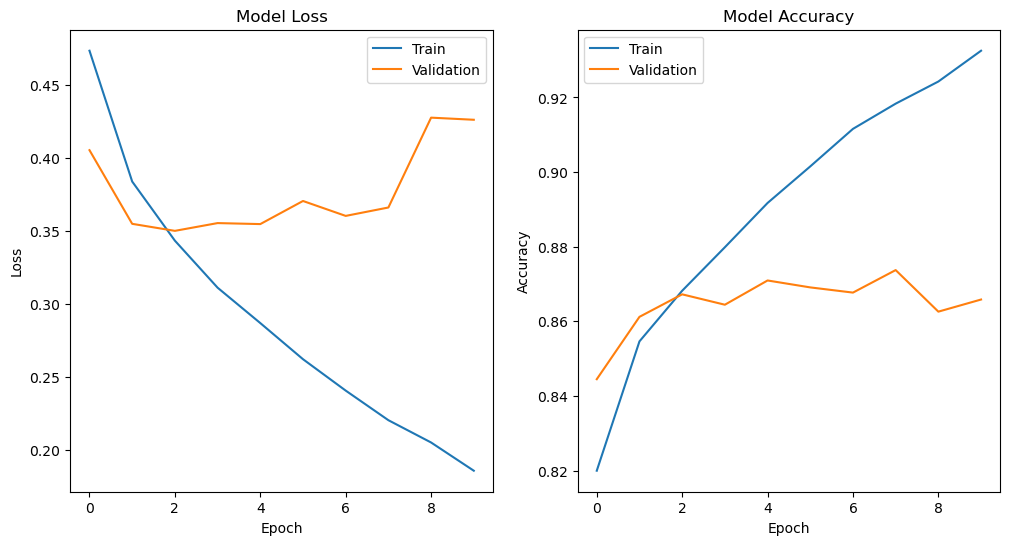

In [22]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

plt.show()

In [23]:
test_predictions = bertlstm_model.predict(test_embeddings)
test_predictions_classes = np.argmax(test_predictions, axis=1)

print(classification_report(test_labels, test_predictions_classes, target_names=['Class 0', 'Class 1', 'Class 2']))

169/169 ━━━━━━━━━━━━━━━━━━━━ 14s 78ms/step
              precision    recall  f1-score   support

     Class 0       0.73      0.56      0.63       714
     Class 1       0.90      0.95      0.92      3838
     Class 2       0.80      0.78      0.79       833

    accuracy                           0.87      5385
   macro avg       0.81      0.76      0.78      5385
weighted avg       0.86      0.87      0.86      5385



In [24]:
lr_reduction = ReduceLROnPlateau(
    monitor='val_loss',         
    factor=0.2,                 
    patience=2,                  
    verbose=1                   
)

early_stopping = EarlyStopping(
    monitor='val_loss',      
    patience=3,              
    restore_best_weights=True  
)


history = bertlstm_model.fit(
    train_embeddings, 
    train_labels, 
    validation_data=(val_embeddings, val_labels), 
    epochs=15,                  
    callbacks=[early_stopping, lr_reduction]  
)

Epoch 1/15
606/606 ━━━━━━━━━━━━━━━━━━━━ 110s 182ms/step - accuracy: 0.9364 - loss: 0.1770 - val_accuracy: 0.8640 - val_loss: 0.4675 - learning_rate: 0.0010
Epoch 2/15
606/606 ━━━━━━━━━━━━━━━━━━━━ 113s 186ms/step - accuracy: 0.9464 - loss: 0.1496 - val_accuracy: 0.8705 - val_loss: 0.4384 - learning_rate: 0.0010
Epoch 3/15
606/606 ━━━━━━━━━━━━━━━━━━━━ 109s 179ms/step - accuracy: 0.9358 - loss: 0.1794 - val_accuracy: 0.8579 - val_loss: 0.4870 - learning_rate: 0.0010
Epoch 4/15
606/606 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.9554 - loss: 0.1277
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
606/606 ━━━━━━━━━━━━━━━━━━━━ 101s 167ms/step - accuracy: 0.9554 - loss: 0.1277 - val_accuracy: 0.8677 - val_loss: 0.5046 - learning_rate: 0.0010
Epoch 5/15
606/606 ━━━━━━━━━━━━━━━━━━━━ 113s 187ms/step - accuracy: 0.9707 - loss: 0.0873 - val_accuracy: 0.8654 - val_loss: 0.5585 - learning_rate: 2.0000e-04


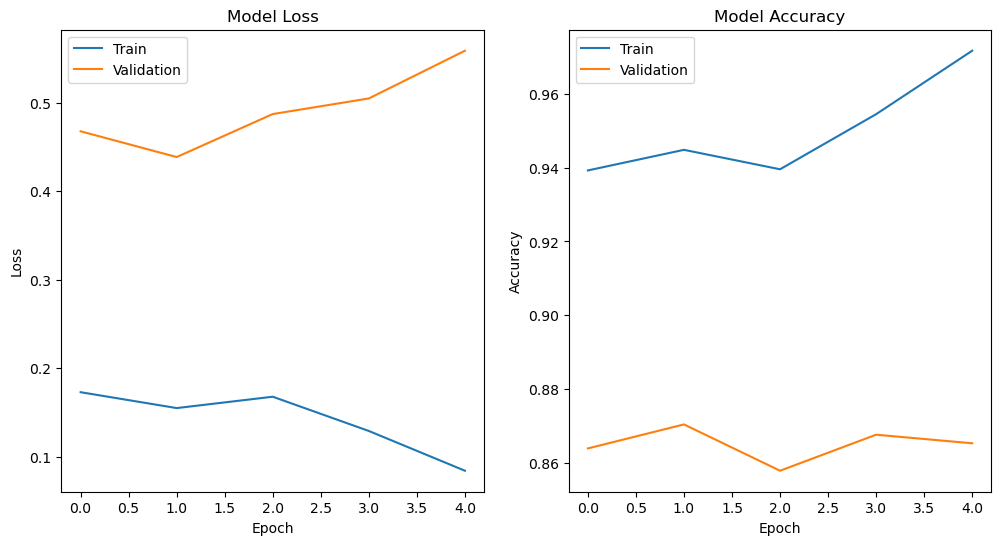

In [25]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

plt.show()

In [26]:
test_predictions = bertlstm_model.predict(test_embeddings)
test_predictions_classes = np.argmax(test_predictions, axis=1)

print(classification_report(test_labels, test_predictions_classes, target_names=['Class 0', 'Class 1', 'Class 2']))

169/169 ━━━━━━━━━━━━━━━━━━━━ 14s 79ms/step
              precision    recall  f1-score   support

     Class 0       0.72      0.54      0.62       714
     Class 1       0.89      0.95      0.92      3838
     Class 2       0.81      0.73      0.77       833

    accuracy                           0.86      5385
   macro avg       0.81      0.74      0.77      5385
weighted avg       0.85      0.86      0.86      5385



# DistilBERT Embeddings with BiLSTM

In [27]:
bertlstm2_model = Sequential([
    Input(shape=(train_embeddings.shape[1], train_embeddings.shape[2])),
    Bidirectional(LSTM(128, return_sequences=True)),  
    Dropout(0.5),
    LSTM(64),
    Dense(3, activation='softmax') 
])

bertlstm2_model.compile(
    optimizer=Adam(learning_rate=1e-5, clipnorm=1.0), 
    loss='sparse_categorical_crossentropy',  
    metrics=['accuracy']
)

history = bertlstm2_model.fit(
    train_embeddings, train_labels, 
    validation_data=(val_embeddings, val_labels), 
    epochs=10,  
    batch_size=32  
)

Epoch 1/10
606/606 ━━━━━━━━━━━━━━━━━━━━ 76s 116ms/step - accuracy: 0.6023 - loss: 0.8544 - val_accuracy: 0.7953 - val_loss: 0.5572
Epoch 2/10
606/606 ━━━━━━━━━━━━━━━━━━━━ 65s 106ms/step - accuracy: 0.7978 - loss: 0.5441 - val_accuracy: 0.8185 - val_loss: 0.4836
Epoch 3/10
606/606 ━━━━━━━━━━━━━━━━━━━━ 64s 105ms/step - accuracy: 0.8205 - loss: 0.4792 - val_accuracy: 0.8259 - val_loss: 0.4631
Epoch 4/10
606/606 ━━━━━━━━━━━━━━━━━━━━ 64s 105ms/step - accuracy: 0.8357 - loss: 0.4406 - val_accuracy: 0.8282 - val_loss: 0.4451
Epoch 5/10
606/606 ━━━━━━━━━━━━━━━━━━━━ 64s 105ms/step - accuracy: 0.8360 - loss: 0.4291 - val_accuracy: 0.8287 - val_loss: 0.4427
Epoch 6/10
606/606 ━━━━━━━━━━━━━━━━━━━━ 66s 109ms/step - accuracy: 0.8385 - loss: 0.4232 - val_accuracy: 0.8333 - val_loss: 0.4282
Epoch 7/10
606/606 ━━━━━━━━━━━━━━━━━━━━ 64s 105ms/step - accuracy: 0.8433 - loss: 0.4110 - val_accuracy: 0.8361 - val_loss: 0.4239
Epoch 8/10
606/606 ━━━━━━━━━━━━━━━━━━━━ 66s 109ms/step - accuracy: 0.8499 - loss: 0

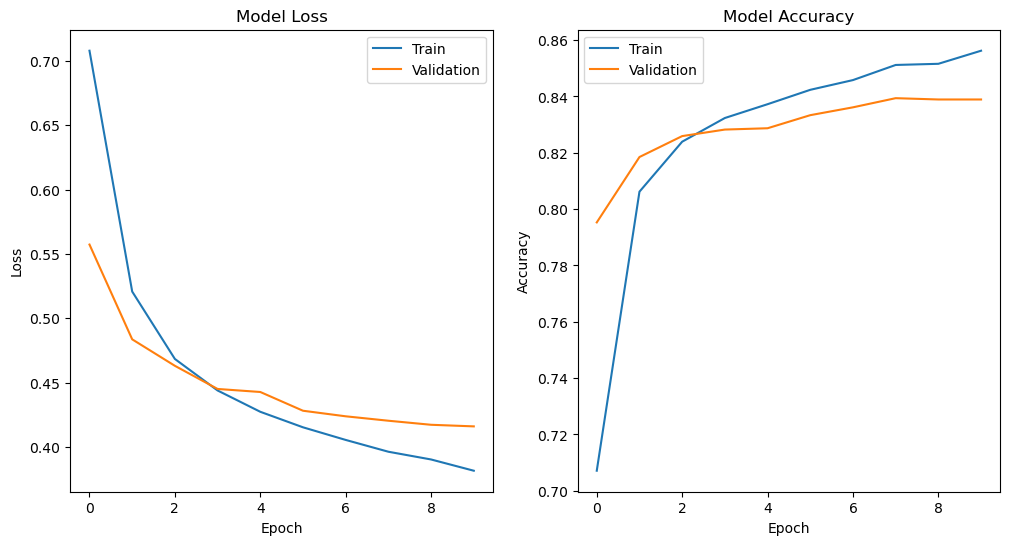

In [28]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

plt.show()

In [29]:
test_predictions = bertlstm2_model.predict(test_embeddings)
test_predictions_classes = np.argmax(test_predictions, axis=1)

print(classification_report(test_labels, test_predictions_classes, target_names=['Class 0', 'Class 1', 'Class 2']))

169/169 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step
              precision    recall  f1-score   support

     Class 0       0.70      0.46      0.56       714
     Class 1       0.89      0.93      0.91      3838
     Class 2       0.72      0.75      0.73       833

    accuracy                           0.84      5385
   macro avg       0.77      0.72      0.73      5385
weighted avg       0.84      0.84      0.84      5385



In [30]:
bertlstm2_model = Sequential([
    Input(shape=(train_embeddings.shape[1], train_embeddings.shape[2])),
    Bidirectional(LSTM(128, return_sequences=True)),  
    Dropout(0.5),
    Bidirectional(LSTM(64)),
    Dense(3, activation='softmax') 
])

bertlstm2_model.compile(
    optimizer=Adam(learning_rate=1e-5, clipnorm=1.0), 
    loss='sparse_categorical_crossentropy',  
    metrics=['accuracy']
)

history = bertlstm2_model.fit(
    train_embeddings, train_labels, 
    validation_data=(val_embeddings, val_labels), 
    epochs=10,  
    batch_size=32  
)

Epoch 1/10
606/606 ━━━━━━━━━━━━━━━━━━━━ 75s 117ms/step - accuracy: 0.6559 - loss: 0.7966 - val_accuracy: 0.8101 - val_loss: 0.5337
Epoch 2/10
606/606 ━━━━━━━━━━━━━━━━━━━━ 71s 118ms/step - accuracy: 0.8087 - loss: 0.5223 - val_accuracy: 0.8301 - val_loss: 0.4644
Epoch 3/10
606/606 ━━━━━━━━━━━━━━━━━━━━ 69s 114ms/step - accuracy: 0.8252 - loss: 0.4657 - val_accuracy: 0.8389 - val_loss: 0.4377
Epoch 4/10
606/606 ━━━━━━━━━━━━━━━━━━━━ 73s 120ms/step - accuracy: 0.8341 - loss: 0.4302 - val_accuracy: 0.8422 - val_loss: 0.4219
Epoch 5/10
606/606 ━━━━━━━━━━━━━━━━━━━━ 65s 107ms/step - accuracy: 0.8376 - loss: 0.4199 - val_accuracy: 0.8491 - val_loss: 0.4102
Epoch 6/10
606/606 ━━━━━━━━━━━━━━━━━━━━ 64s 105ms/step - accuracy: 0.8409 - loss: 0.4081 - val_accuracy: 0.8500 - val_loss: 0.4071
Epoch 7/10
606/606 ━━━━━━━━━━━━━━━━━━━━ 63s 105ms/step - accuracy: 0.8454 - loss: 0.4009 - val_accuracy: 0.8496 - val_loss: 0.3965
Epoch 8/10
606/606 ━━━━━━━━━━━━━━━━━━━━ 63s 104ms/step - accuracy: 0.8497 - loss: 0

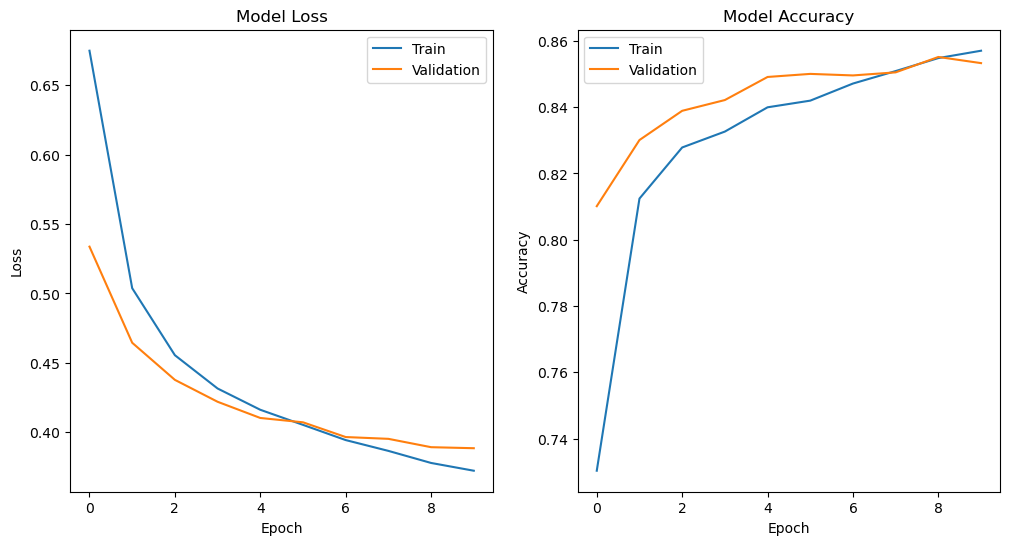

In [31]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

plt.show()

In [32]:
test_predictions = bertlstm2_model.predict(test_embeddings)
test_predictions_classes = np.argmax(test_predictions, axis=1)

print(classification_report(test_labels, test_predictions_classes, target_names=['Class 0', 'Class 1', 'Class 2']))

169/169 ━━━━━━━━━━━━━━━━━━━━ 11s 49ms/step
              precision    recall  f1-score   support

     Class 0       0.71      0.52      0.60       714
     Class 1       0.90      0.92      0.91      3838
     Class 2       0.71      0.78      0.74       833

    accuracy                           0.85      5385
   macro avg       0.77      0.74      0.75      5385
weighted avg       0.84      0.85      0.84      5385



# DistilBERT Embeddings with BiLSTM CNN

In [33]:
bertlstm3_model = Sequential([
    Input(shape=(train_embeddings.shape[1], train_embeddings.shape[2])),
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.5),
    LSTM(64),
    Dense(3, activation='softmax') 
])

bertlstm3_model.compile(
    optimizer=Adam(learning_rate=1e-5, clipnorm=1.0), 
    loss='sparse_categorical_crossentropy',  
    metrics=['accuracy']
)

history = bertlstm3_model.fit(
    train_embeddings, train_labels, 
    validation_data=(val_embeddings, val_labels), 
    epochs=10,  
    batch_size=32  
)

Epoch 1/10
606/606 ━━━━━━━━━━━━━━━━━━━━ 42s 63ms/step - accuracy: 0.7167 - loss: 0.7546 - val_accuracy: 0.8166 - val_loss: 0.5070
Epoch 2/10
606/606 ━━━━━━━━━━━━━━━━━━━━ 37s 62ms/step - accuracy: 0.8156 - loss: 0.4983 - val_accuracy: 0.8310 - val_loss: 0.4629
Epoch 3/10
606/606 ━━━━━━━━━━━━━━━━━━━━ 36s 59ms/step - accuracy: 0.8281 - loss: 0.4530 - val_accuracy: 0.8398 - val_loss: 0.4374
Epoch 4/10
606/606 ━━━━━━━━━━━━━━━━━━━━ 36s 59ms/step - accuracy: 0.8408 - loss: 0.4180 - val_accuracy: 0.8417 - val_loss: 0.4188
Epoch 5/10
606/606 ━━━━━━━━━━━━━━━━━━━━ 36s 59ms/step - accuracy: 0.8506 - loss: 0.3924 - val_accuracy: 0.8403 - val_loss: 0.4085
Epoch 6/10
606/606 ━━━━━━━━━━━━━━━━━━━━ 36s 60ms/step - accuracy: 0.8535 - loss: 0.3864 - val_accuracy: 0.8454 - val_loss: 0.4055
Epoch 7/10
606/606 ━━━━━━━━━━━━━━━━━━━━ 35s 58ms/step - accuracy: 0.8543 - loss: 0.3825 - val_accuracy: 0.8487 - val_loss: 0.3977
Epoch 8/10
606/606 ━━━━━━━━━━━━━━━━━━━━ 36s 59ms/step - accuracy: 0.8632 - loss: 0.3619 - 

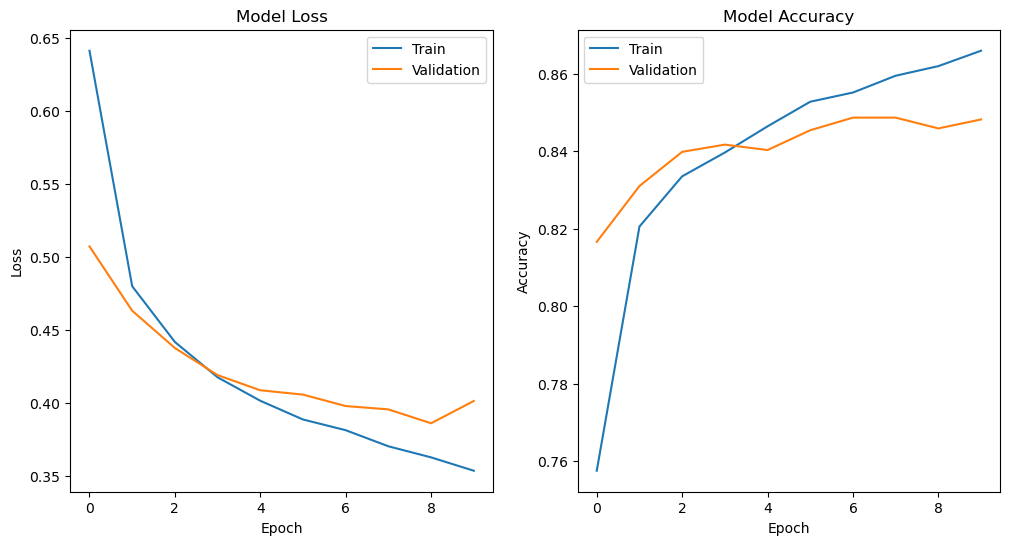

In [34]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

plt.show()

In [35]:
test_predictions = bertlstm3_model.predict(test_embeddings)
test_predictions_classes = np.argmax(test_predictions, axis=1)

print(classification_report(test_labels, test_predictions_classes, target_names=['Class 0', 'Class 1', 'Class 2']))

169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step
              precision    recall  f1-score   support

     Class 0       0.67      0.54      0.60       714
     Class 1       0.89      0.94      0.91      3838
     Class 2       0.78      0.71      0.74       833

    accuracy                           0.85      5385
   macro avg       0.78      0.73      0.75      5385
weighted avg       0.84      0.85      0.84      5385

